# Predict Maturity

Script to predict a50 and s parameters for carcharhinid species using outputs of maturity model

currently based on maturity model #11. change to model 14 when results are ready.

The primary model to describe the shape of maturity ogives uses z-transformed covariates in order to see the effects of each covariate relative to the others (using all z-scores makes effect sizes comparable).  However, to predict new a50 and s values using this model, we need model outputs that allow for the new values to be expressed on teh same scale as the raw data (ie a50 values should be 0-20 and S values 0-10).  Therefore have to run the a secondary model using mean-centred covariates that can be transformed back into the raw data scale.  Can't interpret the results from this model as easily as for the primary model, but more useful for prediction.  



In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os as os

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Function to mean-centre covariates
def centre(x):
    return (x-np.mean(x))

def spanzero(pair):
    out = True
    if all(pair<0) or all(pair>0):
        out = False
    return out

In [12]:
# upload results from model 14
# upload csv file
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
mat = pd.read_csv('mat14_model_results.csv')
mat.head()

,Unnamed: 0,a50x__0,a50x__1,a50x__2,a50x__3,a50x__4,a50x__5,a50x__6,a50x__7,a50x__8,...,mu_S__14,mu_S__15,mu_S__16,mu_S__17,mu_S__18,mu_S__19,mu_S__20,mu_S__21,mu_S__22,S2
0,0,9.984563,8.979059,10.521007,9.558511,5.736421,6.227350,5.736626,5.110483,9.308766,...,1.580194,4.921629,2.049159,2.195520,0.480826,0.657893,2.641485,4.661991,1.212468,0.008492
1,1,10.952929,10.410918,12.532705,11.607398,6.023008,6.520874,6.024673,4.705973,8.957436,...,1.573971,5.989139,2.082327,2.294670,0.490724,0.659519,2.646619,4.963443,1.168644,0.008138
2,2,11.660102,9.330967,11.573590,10.649569,5.819290,6.318266,5.793849,4.441637,8.646411,...,1.464369,4.623351,2.094468,2.247941,0.485734,0.656903,2.645075,5.384801,1.246982,0.008830
3,3,10.999409,8.002221,9.895039,8.972655,4.960838,5.436183,4.919793,4.924834,9.146514,...,1.478065,5.373716,2.157571,2.187386,0.475879,0.648985,2.568008,5.153458,1.213265,0.008360
4,4,10.473783,7.507916,9.332089,8.405431,5.281453,5.797712,5.280965,4.916506,9.196792,...,1.520017,5.286538,2.096564,2.221617,0.469207,0.647865,2.696296,4.442462,1.169357,0.008292


In [13]:
mat.columns.values

array(['Unnamed: 0', 'a50x__0', 'a50x__1', 'a50x__2', 'a50x__3',
       'a50x__4', 'a50x__5', 'a50x__6', 'a50x__7', 'a50x__8', 'a50x__9',
       'a50x__10', 'a50x__11', 'a50x__12', 'a50x__13', 'a50x__14',
       'a50x__15', 'a50x__16', 'a50x__17', 'a50x__18', 'a50x__19',
       'a50x__20', 'a50x__21', 'a50x__22', 'Lmax', 'Depth',
       'Interbirth_interval', 'Amax', 'Litter', 'Offspring_size',
       'Trophic', 'Sx__0', 'Sx__1', 'Sx__2', 'Sx__3', 'Sx__4', 'Sx__5',
       'Sx__6', 'Sx__7', 'Sx__8', 'Sx__9', 'Sx__10', 'Sx__11', 'Sx__12',
       'Sx__13', 'Sx__14', 'Sx__15', 'Sx__16', 'Sx__17', 'Sx__18',
       'Sx__19', 'Sx__20', 'Sx__21', 'Sx__22', 'K-S', 'Amax-S',
       'Trophic-S', 'Ga50', 'a50_sigma', 'GS', 'S_sigma', 'mu_a50__0',
       'mu_a50__1', 'mu_a50__2', 'mu_a50__3', 'mu_a50__4', 'mu_a50__5',
       'mu_a50__6', 'mu_a50__7', 'mu_a50__8', 'mu_a50__9', 'mu_a50__10',
       'mu_a50__11', 'mu_a50__12', 'mu_a50__13', 'mu_a50__14',
       'mu_a50__15', 'mu_a50__16', 'mu_a50__17'

In [14]:
#choose just mat11 columns we want so easier to read

mat = mat.filter(['Ga50', 'Lmax', 'Depth',
       'Interbirth_interval', 'Amax', 'Litter', 'Offspring_size',
       'Trophic', 'GS', 'K-S', 'Amax-S',
       'Trophic-S'], axis=1)


In [6]:
# upload trace
# do I need to do this?
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')

### Model Input Traits Data  

Upload data that was used for maturity model so can calculate mean values for each covariate and use those to transform new data.  New trait data has to be expressed on the same scale as that of the model, so that the effect sizes make sense.  

In [16]:
#upload data
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
adata = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
adata = adata[adata.param_complete==0]
# only species with age-structured data
mdata= adata[adata.SA_mat=='A']
# make an index for stock assessment
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)

#take species level traits

In [17]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
rLMAX = mdata.lmax_cm.values[Sind]
rHAB = mdata.habitat.values[Sind]
rTROPH = mdata.trophic_level.values[Sind]
rOFFSZ = mdata.offspring_size_mm.values[Sind]
#rROFFSZ = mdata.relative_offspring_size.values[Sind]
rLITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
rINTR = mdata.interbirth_interval_yrs.values[Sind]
rAMAT = mdata.age_50_maturity.values[Sind]
rLMAT = mdata.length_maturity_cm.values[Sind]
rLINF = mdata.linf_cm.values[Sind]
rK = mdata.growth_coeff_k.values[Sind]
rAMAX = mdata.age_max_yrs.values[Sind]
rDEP = mdata.depth_ave.values[Sind]
rDEPMAX = mdata.depth_max.values[Sind]
#rTEMP

In [18]:
# get mean values for each covariate
# remember to use correct scale because some were transfromed before centred in model
mLMAX = np.mean(np.log(rLMAX))
mTROPH = np.mean(rTROPH)
mAMAX = np.mean(np.log(rAMAX))
mOFFSZ = np.mean(rOFFSZ/100)
mLITT = np.mean(np.log(rLITT))
mDEP = np.mean(np.log(rDEP))
mK = np.mean(rK)
mINTR = np.mean(rINTR)

In [8]:
mTROPH

4.316521739130435

In [9]:
mAMAX

2.8562644409601403

### New Species Traits Data  

Now transform the trait data for the new species (species we want to predict what their ogives are) in the same way the covariate data was transformed in the model. This way the effect sizes spit out by the model will match the scale of values in the new dataset.

In [19]:
# upload trait values for new species
tcdata = pd.read_excel('tmp_car_traits.xlsx')
# take out incomplete rows
tcdata = tcdata.dropna()
# rename columns
tcdata = tcdata.rename(columns={'lmax':'Lmax'})
tcdata.head()

,species_full,Trophic,Offspring_size,Litter,Amax,K,temp_pref,Depth,Interbirth_Interval,Lmax
0,Galeocerdo cuvier,4.54,821.666667,41.666667,50.0,0.160847,18.1,575.0,2.0,442.5
1,Carcharhinus obscurus,4.28,820.333333,8.833333,37.8,0.041731,19.0,200.0,3.0,348.0
2,Carcharhinus albimarginatus,4.21,737.500000,6.000000,32.0,0.020000,27.1,400.5,1.0,287.5
3,Carcharhinus falciformis,4.51,704.000000,7.100000,30.5,0.098929,21.0,250.0,2.0,313.4
4,Carcharhinus amboinensis,4.28,630.000000,7.666667,30.0,0.145000,27.7,75.0,2.0,243.0


In [20]:
# make a new dataframe with transformed values
tdata = tcdata
tdata.Trophic = tdata.Trophic-mTROPH
tdata.Offspring_size = (tdata.Offspring_size/100)-mOFFSZ 
tdata.Litter = np.log(tdata.Litter)- mLITT
tdata.Amax = np.log(tdata.Amax) - mAMAX
tdata.K = tdata.K - mK
tdata.Depth = np.log(tdata.Depth) - mDEP
tdata.Interbirth_Interval = tdata.Interbirth_Interval - mINTR
tdata.Lmax = np.log(tdata.Lmax)- mLMAX
tdata.head()

,species_full,Trophic,Offspring_size,Litter,Amax,K,temp_pref,Depth,Interbirth_Interval,Lmax
0,Galeocerdo cuvier,0.223478,2.613188,1.931287,1.055759,-0.034787,18.1,2.012510,0.130435,0.949893
1,Carcharhinus obscurus,-0.036522,2.599855,0.380118,0.776045,-0.153902,19.0,0.956458,1.130435,0.709655
2,Carcharhinus albimarginatus,-0.106522,1.771522,-0.006655,0.609471,-0.175634,27.1,1.650854,-0.869565,0.518675
3,Carcharhinus falciformis,0.193478,1.436522,0.161680,0.561462,-0.096705,21.0,1.179601,0.130435,0.604933
4,Carcharhinus amboinensis,-0.036522,0.696522,0.238467,0.544933,-0.050634,27.7,-0.024372,0.130435,0.350514


## Species Predictions  

Combine model results with new species trait data to predict new species a50 and s

In [21]:
nrows = tdata.shape[0]

In [22]:
# Create empty containers to hold results from combining model with new data
# note that np.empty doesn't fill the array with 0s, it just puts random values in that you then have to replace

#info on a50
a50mu = np.empty(nrows)
a50l95 = np.empty(nrows)
a50l50 = np.empty(nrows)
a50u95 = np.empty(nrows)
a50u50 = np.empty(nrows)

# info on s
smu = np.empty(nrows)
sl95 = np.empty(nrows)
sl50 = np.empty(nrows)
su95 = np.empty(nrows)
su50 = np.empty(nrows)

AGE = list(range(0,51))

# empty matrices for age structured data
matmu = np.zeros((nrows, len(AGE)))
matl95 = np.zeros((nrows, len(AGE)))
matl50 = np.zeros((nrows, len(AGE)))
matu95 = np.zeros((nrows, len(AGE)))
matu50 = np.zeros((nrows, len(AGE)))

In [25]:
for i in range(nrows):

    # make temporary object with data from just one species at a time
    tmp = tdata.iloc[i]
    # create vectors of a50 and S values for each species
    Exa50 = mat['Ga50'].values + mat['Amax'].values*tmp['Amax'] + mat['Trophic'].values*tmp['Trophic'] + mat['Lmax'].values*tmp['Lmax'] + mat['Depth'].values*tmp['Depth'] + mat['Interbirth_interval'].values*tmp['Interbirth_Interval'] + mat['Litter'].values*tmp['Litter'] + mat['Offspring_size'].values*tmp['Offspring_size']
    ExS = mat['GS'] + mat['K-S'].values*tmp['K'] + mat['Trophic-S'].values*tmp['Trophic'] + mat['Amax-S'].values*tmp['Amax']
    
    # create age structured data
    mu = np.array([1/(1+np.exp(-s*(AGE-a))) for s,a in zip(ExS, Exa50)])
        
        
    # a50 values to empty a50 objects
    a50mu[i] = np.median(Exa50)
    a50l95[i] = np.percentile(Exa50, 2.5)
    a50l50[i] = np.percentile(Exa50, 25)
    a50u95[i] = np.percentile(Exa50, 97.5)
    a50u50[i] = np.percentile(Exa50, 50)
    
      # add S values to empty S objects
    smu[i] = np.median(ExS)
    sl95[i] = np.percentile(ExS, 2.5)
    sl50[i] = np.percentile(ExS, 25)
    su95[i] = np.percentile(ExS, 97.5)
    su50[i] = np.percentile(ExS, 50)
    
    # add age-structured maturity data to empty objects
    # note choosing to calculate along 0 axis is like calculate a total row at the bottom of a spreadsheet
    matmu[i] = np.median(mu, axis=0)
    matl95[i] = np.percentile(mu,2.5, axis=0)
    matl50[i] = np.percentile(mu, 25, axis=0)
    matu95[i] = np.percentile(mu, 97.5, axis=0)
    matu50[i] = np.percentile(mu, 50, axis=0)

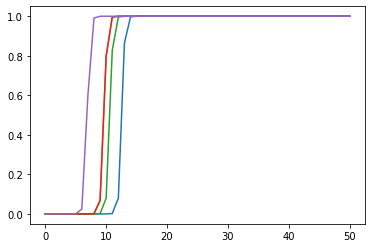

In [33]:
# Check for loop results
# species 21 is oceanic whitetip shark
plt.plot(AGE, matl95[21])
plt.plot(AGE, matmu[21])
plt.plot(AGE, matl50[21])
plt.plot(AGE, matu50[21])
plt.plot(AGE, matu95[21])

In [32]:
tdata.iloc[21]

species_full           Carcharhinus longimanus
Trophic                              -0.156522
Offspring_size                       0.0965217
Litter                                0.478853
Amax                                 -0.217207
K                                       0.1917
temp_pref                                 27.5
Depth                                 0.403072
Interbirth_Interval                   0.130435
Lmax                                  0.433401
Name: 22, dtype: object

In [39]:
matmu[21]

array([5.08144137e-18, 3.16596221e-16, 2.31079530e-14, 1.46790178e-12,
       8.83155116e-11, 5.27528178e-09, 3.44901554e-07, 2.21332752e-05,
       1.20054073e-03, 6.77474952e-02, 7.98611113e-01, 9.95637117e-01,
       9.99925608e-01, 9.99998787e-01, 9.99999980e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

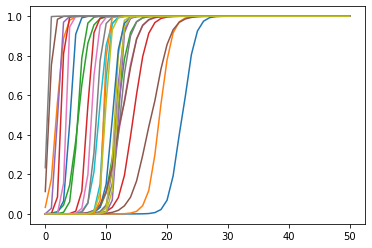

In [40]:
# Plot all new ogives & save figure

for i in range(nrows):
    plt.plot(AGE, matmu[i])
    

os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('predicted-ogives.jpg')

In [ ]:
# save results 
